In [1]:
import os

from grid import scale, get_multiplicator
from simulation.simulation import Simulation, DEFAULT_PARAMETERS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors
import matplotlib.ticker as mticker
import math
import pickle
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec

# Radiation repartition

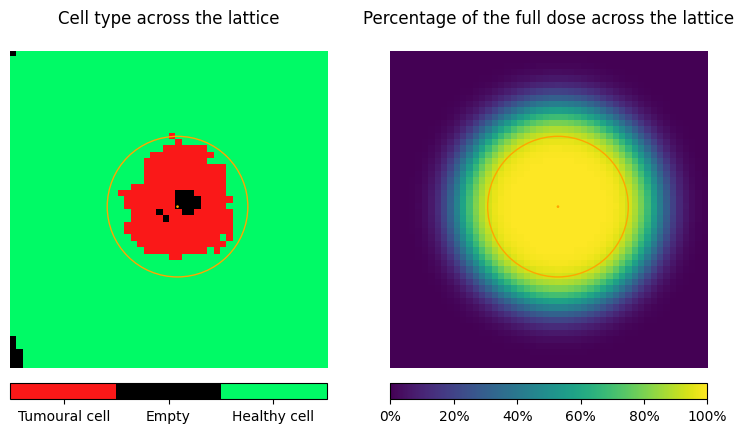

In [2]:
colors = ["#FA1818", "black", "#00FA66"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
size = 50
simu = Simulation(size, size, DEFAULT_PARAMETERS)
simu.cycle(350)
fig, axis = plt.subplots(1, 2, figsize=(9,5))
axis[0].axis('off')
axis[1].axis('off')
truc = axis[0].imshow(simu.get_cells_type(color=False), cmap=cmap, norm=norm)
fig.colorbar(truc, ax=axis[0], ticks=[-0.66, 0, 0.66], format=mticker.FixedFormatter(['Tumoural cell', 'Empty', 'Healthy cell']), orientation='horizontal', fraction=0.046, pad=0.04)
simu.grid.compute_center()
center = (simu.grid.center_x, simu.grid.center_y)
radius = simu.grid.tumor_radius(center[0], center[1])
dose = 100

radiation = np.zeros((size, size))
multiplicator = get_multiplicator(dose, radius)
for i in range(size):
    for j in range(size):
        dist = math.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
        radiation[i, j] = scale(radius, dist, multiplicator)
radiation = axis[1].matshow(radiation, vmin=0, vmax=100)
cbar = fig.colorbar(radiation, ax=axis[1], orientation='horizontal', fraction=0.046, pad=0.04, ticks=range(0,120,20))
cbar.ax.set_xticklabels([f"{i}%" for i in range(0,120,20)])
axis[0].add_patch(Circle((center[1], center[0]), radius, fill=False, color="orange"))
axis[0].add_patch(Circle((center[1], center[0]), 0.1, fill=True, color="orange"))
axis[1].add_patch(Circle((center[1], center[0]), radius, fill=False, color="orange"))
axis[1].add_patch(Circle((center[1], center[0]), 0.1, fill=True, color="orange"))
axis[0].set_title('Cell type across the lattice', pad=20)
axis[1].set_title('Percentage of the full dose across the lattice', pad=20)
plt.savefig("radiation_repartition.pdf")
plt.show()

# Survival probabilities

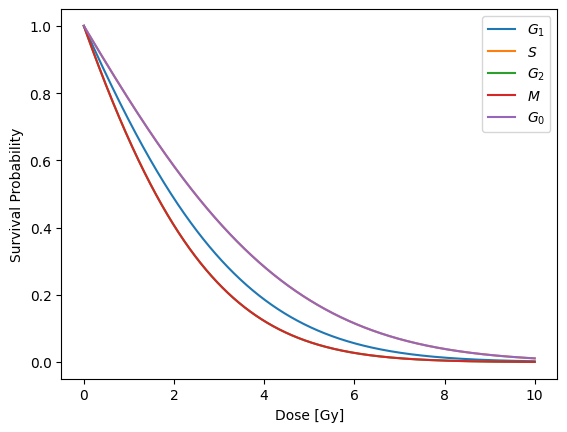

In [7]:
radiosensitivities = {
    "$G_1$": 1,
    "$S$": .75,
    "$G_2$": 1.25,
    "$M$": 1.25,
    "$G_0$": .75
}

alpha_tumour = 0.3
beta_tumour = 0.03
alpha_healthy = 0.15
beta_healthy = 0.03
oer_m = 3.0
k_m = 3.0
dose_max = 10


for key, value in radiosensitivities.items():
    X = np.linspace(0, dose_max, 10000)
    survival_probability = np.exp(value * (-alpha_tumour * X - beta_tumour * (X ** 2)))
    plt.plot(X, survival_probability, label=key)
plt.xlabel("Dose [Gy]")
plt.ylabel("Survival Probability")
plt.legend()
plt.savefig(os.path.join("pictures","survival_probability.png"))

# Simple image

In [61]:
os.makedirs("pictures", exist_ok=True)
simu = Simulation(64,64, DEFAULT_PARAMETERS)
simu.cycle(350)
for i in range(8):
    plt.matshow(simu.get_cells_type(color=True))
    plt.axis('off')
    plt.tight_layout(pad=0.0)
    plt.savefig(os.path.join("pictures",f"cell_type_{350+i*100}"), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.matshow(simu.get_cells_density())
    plt.axis('off')
    plt.tight_layout(pad=0.0)
    plt.savefig(os.path.join("pictures",f"cell_density_{350+i*100}"), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.matshow(simu.get_oxygen(), cmap="cividis")
    plt.axis('off')
    plt.tight_layout(pad=0.0)
    plt.savefig(os.path.join("pictures",f"oxygen_{350+i*100}"), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.matshow(simu.get_glucose(), cmap="plasma")
    plt.axis('off')
    plt.tight_layout(pad=0.0)
    plt.savefig(os.path.join("pictures",f"glucose_{350+i*100}"), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

    simu.cycle(100)

/tmp/ipykernel_249805/1825222968.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)
/tmp/ipykernel_249805/1825222968.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)
/tmp/ipykernel_249805/1825222968.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)
/tmp/ipykernel_249805/1825222968.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)


# Evolution cell cycle

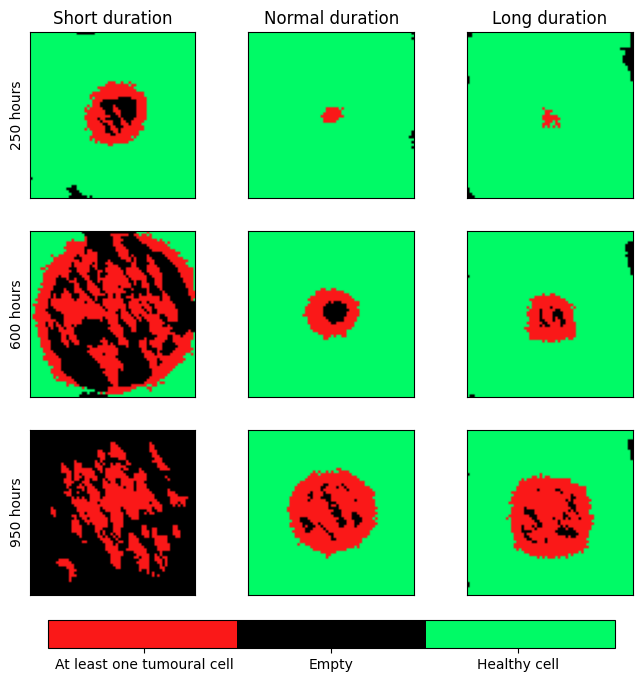

In [26]:
colors = ["#FA1818", "black", "#00FA66"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots(3,3, figsize=(8,8))
simu_normal= Simulation(64,64, DEFAULT_PARAMETERS)
DEFAULT_PARAMETERS["cell_cycle"] = 12
simu_low= Simulation(64,64, DEFAULT_PARAMETERS)
DEFAULT_PARAMETERS["cell_cycle"] = 36
simu_high= Simulation(64,64, DEFAULT_PARAMETERS)

im = None

for i, hours in enumerate([250,600,950]):
    simu_normal.cycle(hours - simu_normal.hours_passed)
    simu_low.cycle(hours - simu_low.hours_passed)
    simu_high.cycle(hours - simu_high.hours_passed)
    for j in range(3):
        ax[i,j].xaxis.set_tick_params(labelbottom=False)
        ax[i,j].yaxis.set_tick_params(labelleft=False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
    ax[i,0].set_ylabel(f"{hours} hours")
    
    im = ax[i,0].imshow(simu_low.get_cells_type(color=True), cmap=cmap, norm=norm)
    ax[i,1].imshow(simu_normal.get_cells_type(color=True), cmap=cmap, norm=norm)
    ax[i,2].imshow(simu_high.get_cells_type(color=True), cmap=cmap, norm=norm)

ax[0,0].set_title('Short duration')
ax[0,1].set_title('Normal duration')
ax[0,2].set_title('Long duration')
fig.colorbar(im, ax=ax, ticks=[-0.66, 0, 0.66], format=mticker.FixedFormatter(['At least one tumoural cell', 'Empty', 'Healthy cell']), orientation='horizontal', fraction=0.046, pad=0.04)
plt.savefig(f"pictures/cell_cycle_variation.pdf", bbox_inches='tight', dpi=250)

# Evolution of the nutrient consumption for cancer cells

In [3]:
simu_normal= Simulation(64,64, DEFAULT_PARAMETERS)
DEFAULT_PARAMETERS["average_cancer_oxygen_consumption"] = 12
simu_low= Simulation(64,64, DEFAULT_PARAMETERS)
DEFAULT_PARAMETERS["average_cancer_oxygen_consumption"] = 30
simu_high= Simulation(64,64, DEFAULT_PARAMETERS)

oxygen = {"low":list(),"normal":list(),"high":list()}
glucose = {"low":list(),"normal":list(),"high":list()}

for i, hours in enumerate([250,600,950]):
    simu_normal.cycle(hours - simu_normal.hours_passed)
    simu_low.cycle(hours - simu_low.hours_passed)
    simu_high.cycle(hours - simu_high.hours_passed)
    
    oxygen["low"].append(simu_low.get_oxygen())
    glucose["low"].append(simu_low.get_glucose())
    
    oxygen["normal"].append(simu_normal.get_oxygen())
    glucose["normal"].append(simu_normal.get_glucose())
    
    oxygen["high"].append(simu_high.get_oxygen())
    glucose["high"].append(simu_high.get_glucose())

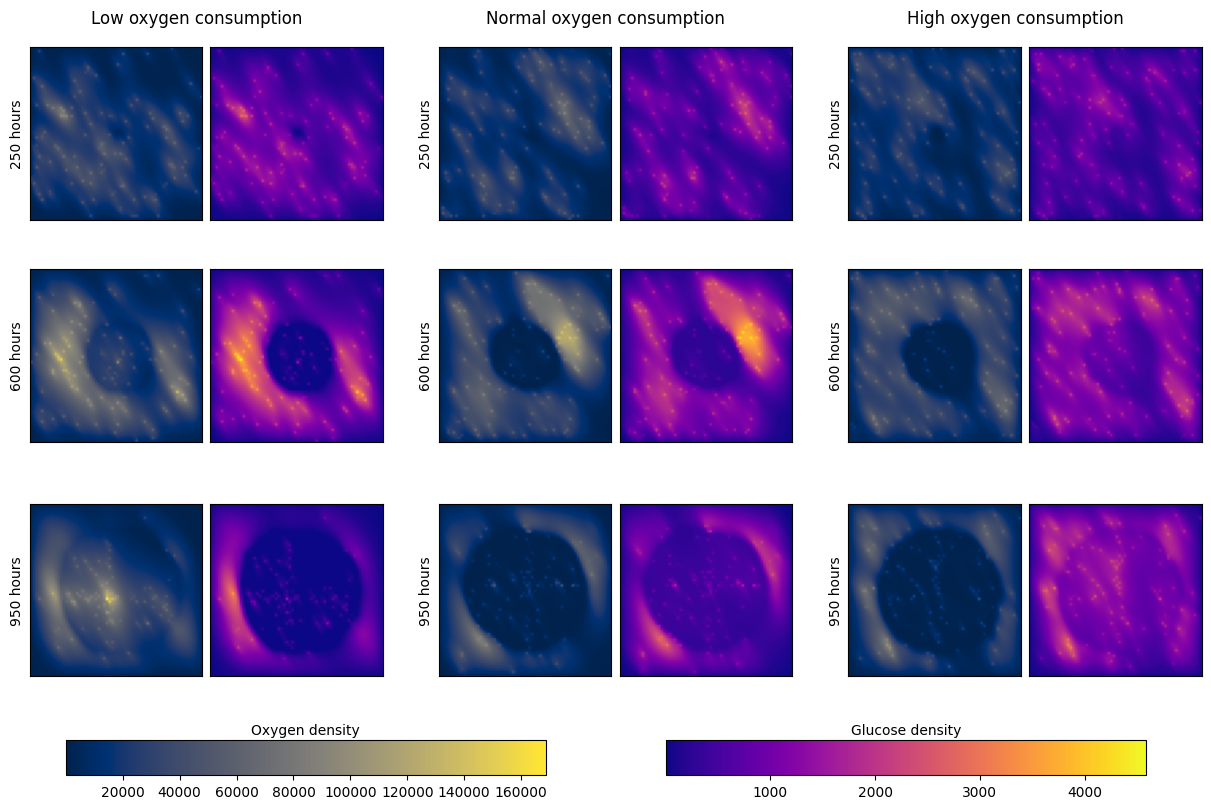

In [26]:
min_oxygen = min(np.min(oxygen["low"]), np.min(oxygen["normal"]),np.min(oxygen["high"]))
max_oxygen = max(np.max(oxygen["low"]), np.max(oxygen["normal"]),np.max(oxygen["high"]))

min_glucose = min(np.min(glucose["low"]), np.min(glucose["normal"]),np.min(glucose["high"]))
max_glucose = max(np.max(glucose["low"]), np.max(glucose["normal"]),np.max(glucose["high"]))

fig = plt.figure(figsize=(12, 7), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=3, wspace=0.07)
axs = [subfig.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

oxygen_img = None
glucose_img = None
for row, hours in enumerate([250,600,950]):
    for col, scale in enumerate(["low","normal","high"]):
        subfigs[0, col].suptitle(f"{['Low','Normal','High'][col]} oxygen consumption")
        for iax, ax in enumerate(axs[3*row+col]):
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)
            ax.set_yticks([])
            ax.set_xticks([])
            if iax == 0:
                ax.set_ylabel(f"{hours} hours")
                oxygen_img = ax.imshow(oxygen[scale][row], vmin=min_oxygen, vmax=max_oxygen, cmap="cividis")
            else:
                glucose_img = ax.imshow(glucose[scale][row], vmin=min_glucose, vmax=max_glucose,cmap="plasma")

col_w = 0.4
col_h = 0.05
col_b = -0.1
col_l = (0.05,0.55)
oxygen_colorbar = fig.colorbar(oxygen_img, cax = plt.axes((col_l[0],col_b, col_w, col_h)), orientation='horizontal', fraction=0.046, pad=0.04, label="Oxygen density")
glucose_colorbar = fig.colorbar(glucose_img, cax = plt.axes((col_l[1],col_b, col_w, col_h)), orientation='horizontal', fraction=0.046, pad=0.04, label="Glucose density")

oxygen_colorbar.ax.xaxis.set_label_position('top')

glucose_colorbar.ax.xaxis.set_label_position('top')

plt.savefig("pictures/evolution_oxygen_nutrient_consumption.pdf", bbox_inches='tight')


# Best result Florian

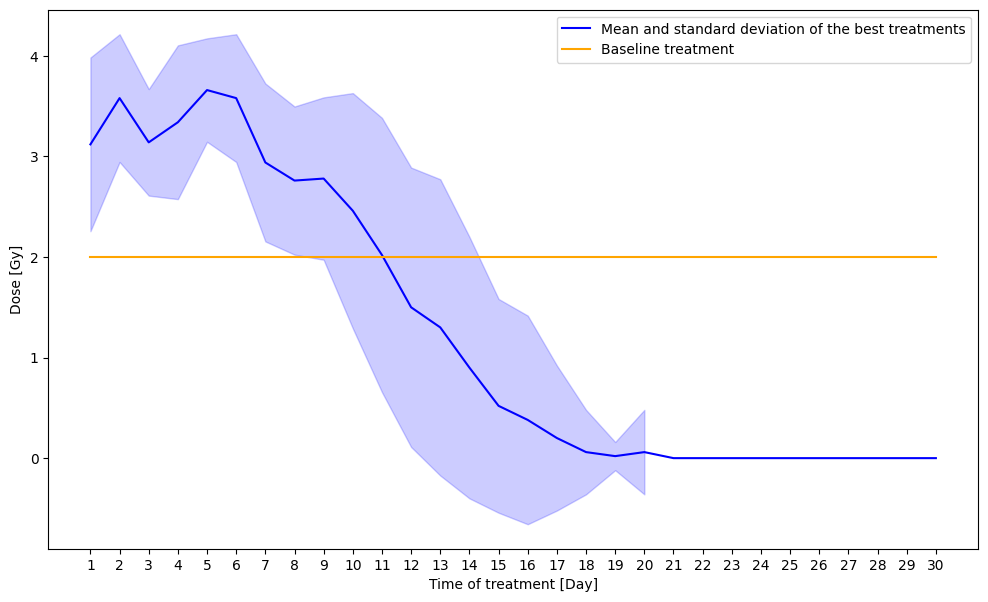

In [3]:
result_florian = pickle.load(open("best_result_rl_Florian.pickle","rb"))
A = dict()
for doses_per_hour in result_florian["doses_per_hour"].values():
    for time, dose in doses_per_hour.items():
        if A.get(time, None) is None:
            A[time]=[dose]
        else:
            A[time].append(dose)
dose_per_time = {key:np.pad(value, (0, len(A[0]) - len(value)), mode='constant') for key, value in A.items()}
mean = {key:np.mean(value) for key, value in dose_per_time.items()}
std = {key:np.std(value) for key, value in dose_per_time.items()}
X = np.array(list(dose_per_time.keys()))
Y_mean = np.array([mean[key] for key in X])
Y_std = np.array([std[key] for key in X])
fig = plt.figure(figsize=(12, 7))
plt.plot(np.arange(350,1070,24), np.pad(Y_mean, (0,30-len(Y_mean)), mode="constant"), color="blue", label="Mean and standard deviation of the best treatments")
plt.fill_between(X+350, Y_mean-Y_std, Y_mean+Y_std, alpha=0.2, color="blue")
plt.plot(np.arange(350,1070,24), np.full(30, 2), color="orange", label="Baseline treatment")
plt.xticks(np.arange(350,1070,24), np.arange(1,31))
plt.xlabel("Time of treatment [Day]")
plt.ylabel("Dose [Gy]")
plt.legend()
plt.savefig(os.path.join("pictures","treatment_doses_per_hour.pdf"), bbox_inches='tight')
